# Code to make an eccentric ring & include a forced eccentricity profile

Author -- Joshua Lovell, July 31 2024

Contact -- joshualovellastro@gmail.com

Purpose -- Provide code required to correctly model the surface density around an eccentric ring. The code presented here is the basis of the eccentric ring models adopted by Lovell et al. 2024 (Fomalhaut, in review) and utilised in Lynch & Lovell 2022 (albeit in the restricted cases for fixed n=-1,0,1).

Limitations -- 

- 1) The code here is purely face-on, i.e., there is no projection to the sky plane, nor is there any vertical structure.
- 2) Orbital intersections limit how large the eccentricity can become before the model fails. Since this can impact some regions of a disk and not others, one should check the surface density profiles to see if artificial gaps in data have been introduced.

## How to model forced eccentricity rings

### First -- install all library dependencies. Fortunately, there aren't many and you are likely to already have these installed

In [79]:
#pip install numpy
#pip install scipy
#pip install seaborn ### seaborn cmaps >>> matplotlib cmaps

### Second -- import all required libraries for the functions to run

In [80]:
%matplotlib inline
from numpy import cos, sqrt, exp, log, pi, abs, where, arctan2, zeros, linspace, max, meshgrid
import scipy.optimize as sciOpt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import rc
plt.rc('font', family='serif')
plt.rcParams["font.family"] = "fantasy"

### Third -- define the eccentric ring models. There are two code blocks here, which is the same function, one in polar coordinates and (for ease) one in cartesian coordinates.

In [81]:
#definitions
def Sigma_faceOnFlat_polar(r, phi,  r0, wring, Kcon, n, omegaf, prof):
    # r in au, phi in radians, r0 in au, wring in au, Kcon units vary (au^-n), n unitless, omegaf in radians
    # AT ALL TIMES: e:= Kcon*(a**n); this is just some parametrisation
    def objFun(a): # solve a(r)
        return r - ( a*(1.- (Kcon*(a**n))**2.) / (1.0+(Kcon*(a**n))*cos(phi-omegaf)) )
    try:
       a = sciOpt.brentq(objFun,r/2.,10.*r) #brentq faster than some other choices, there might be more optimal choices however
    except:
       return 0.0

    if Kcon*(a**n) >0.999999999: # eccentricities cannot exceed 1
       return 0.0
    else:
       cosE = ( cos(phi-omegaf) + Kcon*(a**n) ) / ( 1.0 + ((Kcon*(a**n))*cos(phi-omegaf) ) )

       q = n*Kcon*(a**n) / ( 1.-((n+1.)*((Kcon*(a**n))**2.0)) ) # orbital intersection parameter
       if abs(q) > 0.999999999: # orbital intersection parameter cannot exceed 1
          return 0.0

       j = ( ( 1.0-Kcon*(a**n)*(Kcon*(a**n)+n*Kcon*(a**n)) )/ ( sqrt( 1.-(Kcon*(a**n))**2. ) ) )*(1.-q*cosE) # j ensures correct mass per orbit around the ring
       sigma =wring/(2.0*sqrt(2.0*log(2.0)))  # standard deviation to go into the Gaussian profile normalization

    if prof=='Gaussian':
      return exp(  - (a-r0)**2.0/(2.0*sigma**2))/(sqrt(2*pi)*sigma*j) # Gaussian profile
    elif prof=='Tophat':
      return (1./(2*wring*j))*where(abs(r0-a)<wring,1,0) # TopHat profile
    else:
      print('Radial profile not specified correctly -- aborting')
      return

def Sigma_faceOnFlat_cartn(x, y,  r0, wring, Kcon, n, omegaf, prof):
    # x,y in au, r0 in au, wring in au, Kcon units vary (au^-n), n unitless, omegaf in radians
    # AT ALL TIMES: e:= Kcon*(a**n); this is just some parametrisation
    r = sqrt(x**2.0 + y**2.0)
    phi = arctan2(y,x)
    def objFun(a):
        return r - ( a*(1.- (Kcon*(a**n))**2.) / (1.0+(Kcon*(a**n))*cos(phi-omegaf)) )
    try:
       a = sciOpt.brentq(objFun,r/2.,10.*r) #brentq faster than some other choices, there might be more optimal choices however
    except:
       return 0.0
    if Kcon*(a**n) >0.999999999:
       return 0.0
    else:
       cosE = ( cos(phi-omegaf) + Kcon*(a**n) ) / ( 1.0 + ((Kcon*(a**n))*cos(phi-omegaf) ) )

       q = n*Kcon*(a**n) / ( 1.-((n+1.)*((Kcon*(a**n))**2.0)) )
       if abs(q) > 0.999999999:
          return 0.0

       j = ( ( 1.0-Kcon*(a**n)*(Kcon*(a**n)+n*Kcon*(a**n)) )/ ( sqrt( 1.-(Kcon*(a**n))**2. ) ) )*(1.-q*cosE)
       sigma =wring/(2.0*sqrt(2.0*log(2.0)))  # standard deviation. This goes into the normalization

    if prof=='Gaussian':
      return exp(  - (a-r0)**2.0/(2.0*sigma**2))/(sqrt(2*pi)*sigma*j) # Gaussian profile
    elif prof=='Tophat':
      return (1./(2*wring*j))*where(abs(r0-a)<wring,1,0) # TopHat profile
    else:
      print('Radial profile not specified correctly -- aborting')
      return

def drawEccentricModels(Sigma_prn_polar,Sigma_prn_cartn,axisText):
  ncols,nrows=2,1
  fig,axs=plt.subplots(nrows=nrows,ncols=ncols,sharex=True,sharey=True, figsize=(16,8.0))

  colname='rocket' #because it is nice
  colmap = sns.color_palette(colname, as_cmap=True)

  axs[0].imshow(Sigma_prn_polar[:,:],cmap=colmap, origin='lower')
  #axs[0].contourf(Sigma_prn_0[:,:],levels=[0.1,0.3,0.5,0.7,0.9,1.0],cmap=colmap) # Turn on for graduated image
  axs[0].contour(Sigma_prn_polar[:,:],levels=[0.1],colors='white',linestyles='dashed',linewidths=0.5)
  axs[1].imshow(Sigma_prn_cartn[:,:],cmap=colmap, origin='lower')
  #axs[1].contourf(Sigma_prn_0C[:,:],levels=[0.1,0.3,0.5,0.7,0.9,1.0],cmap=colmap) # Turn on for graduated image
  axs[1].contour(Sigma_prn_cartn[:,:],levels=[0.1],colors='white',linestyles='dashed',linewidths=0.5)
  axs[0].text(110,15,s=axisText,color='w',bbox=dict(facecolor='black', alpha=0.0,edgecolor='black'),fontsize=22)

  #now neaten your plots, add graphics
  for i in range(ncols):
    axs[0].arrow(15,15,0,40,color='w',head_width=3,head_length=8)
    axs[0].arrow(15,15,40,0,color='w',head_width=3,head_length=8)
    axs[0].text(55,25,s=r'$\phi$',color='w',bbox=dict(facecolor='black', alpha=0.0,edgecolor='black'),fontsize=18)
    axs[0].text(22,55,s=r'$r$',color='w',bbox=dict(facecolor='black', alpha=0.0,edgecolor='black'),fontsize=18)
    axs[1].plot(len(xs)/2.,len(ys)/2.,marker='*',color='w',markersize=12)

  for i in range(ncols):
    for j in range(nrows):
      axs[j].set_xticks([])
      axs[j].set_yticks([])

  plt.subplots_adjust(top=1.0, bottom=0.0, left=0.002, right=0.998, hspace=0.01, wspace=0.01)
  plt.show()

def getEccentricRing(gridParams, eRingParams, norm):
  # gridParams is a 5-component list, requiring rmin, rmax, phimin, phimax, polar-resolution
  # this makes an equivalent resolution cartesian grid.
  # eRingParams is a 5-component list, which takes r0 [au], wring [au], e0 [eccentricity at location r0], omega [rad.], and profileChoice
  # this function first creates the ring grid, and then calculates the eccentric ring surface density at each ring grid location
  # it then returns a 2D array (normalised if 'norm=True')
  
  # create grid
  rs, phis = linspace(gridParams[0],  gridParams[1], gridParams[4]), linspace(gridParams[2],  gridParams[3], gridParams[4])
  xs, ys   = linspace(-gridParams[1], gridParams[1], gridParams[4]), linspace(-gridParams[1], gridParams[1], gridParams[4])
  Sigma_prnP = zeros((len(rs),len(phis)))
  Sigma_prnC = zeros((len(xs),len(ys)))

  # calculate surface density grids
  r0, wring, Kcon, npow, omegaf, profileChoice = eRingParams[0], eRingParams[1], eRingParams[2], eRingParams[3], eRingParams[4], eRingParams[5]
  for i in range(len(rs)): # this stage could be vectorised to speed up, for 250x250 grid, time relatively short however
    for k in range(len(phis)):
      Sigma_prnP[i][k] = Sigma_faceOnFlat_polar(rs[i], phis[k], r0, wring, Kcon, npow, omegaf, profileChoice)
      Sigma_prnC[i][k] = Sigma_faceOnFlat_cartn(xs[i], ys[k],   r0, wring, Kcon, npow, omegaf, profileChoice)

  if norm==True:
    Sigma_prnP = Sigma_prnP / max(Sigma_prnP) ##normalisation on
    Sigma_prnC = Sigma_prnC / max(Sigma_prnC) ##normalisation on
    return Sigma_prnP, Sigma_prnC
  else:
    return Sigma_prnP, Sigma_prnC

Note that each has two commented out return lines. One can turn on different parametric forms here. Currently a Gaussian profile is used, however any radial profile can be adopted here. I have coded in a TopHat as an example (as trialed in the Fomalhaut paper) however you may implement here any such radial profile you wish.

### Fourth -- define your ring parameters, let's start simple

In [97]:
# let's choose some parameters
r0, e0, wring, omegaf, npow = 90.0, 0.1, 25.0, 0.0, 0.0
Kcon = e0*r0**(-npow) #this parametrisation is used but could be incorporated into the function
profileChoice = 'Gaussian' #'Tophat'
eRingParams = [r0, wring, Kcon, npow, omegaf, profileChoice]

Note: the code is relatively 'expensive' for n=0. In this case, we do not strictly need to solve the "def objFun(a): # solve a(r)" step since there is a single solution to the orbit being calculated. However, when eccentric gradients are included, there are non-physical orbital solutions that must be eliminated (hence the objFun(a) cuts the radial space within which radii are calculated) in order for us to actually get the correct orbit. 

### Fifth -- define your grid
Since we have chosen to make an eccentric ring with these parameters, we should probably let the grid extend to ~140au, and for this example aim for approx 1-2 pixels per au (though this is for most applications a very high resolution, n=250 really doesn't take so long to calculate). We will plot the same data on two grids; one polar (left) and one cartesian (right).

In [98]:
rmin, rmax, phimin, phimax, resolution = 0.0, 140.0, 0.0, 2*pi, 250
gridParams = [rmin, rmax, phimin, phimax, resolution]

### Finally --  calculate and plot your densities!
Here I folded the ring generation and plotting tools into two generic functions. Of coursse, feel free to play with these if you want different image specifications, or ways to grid data.

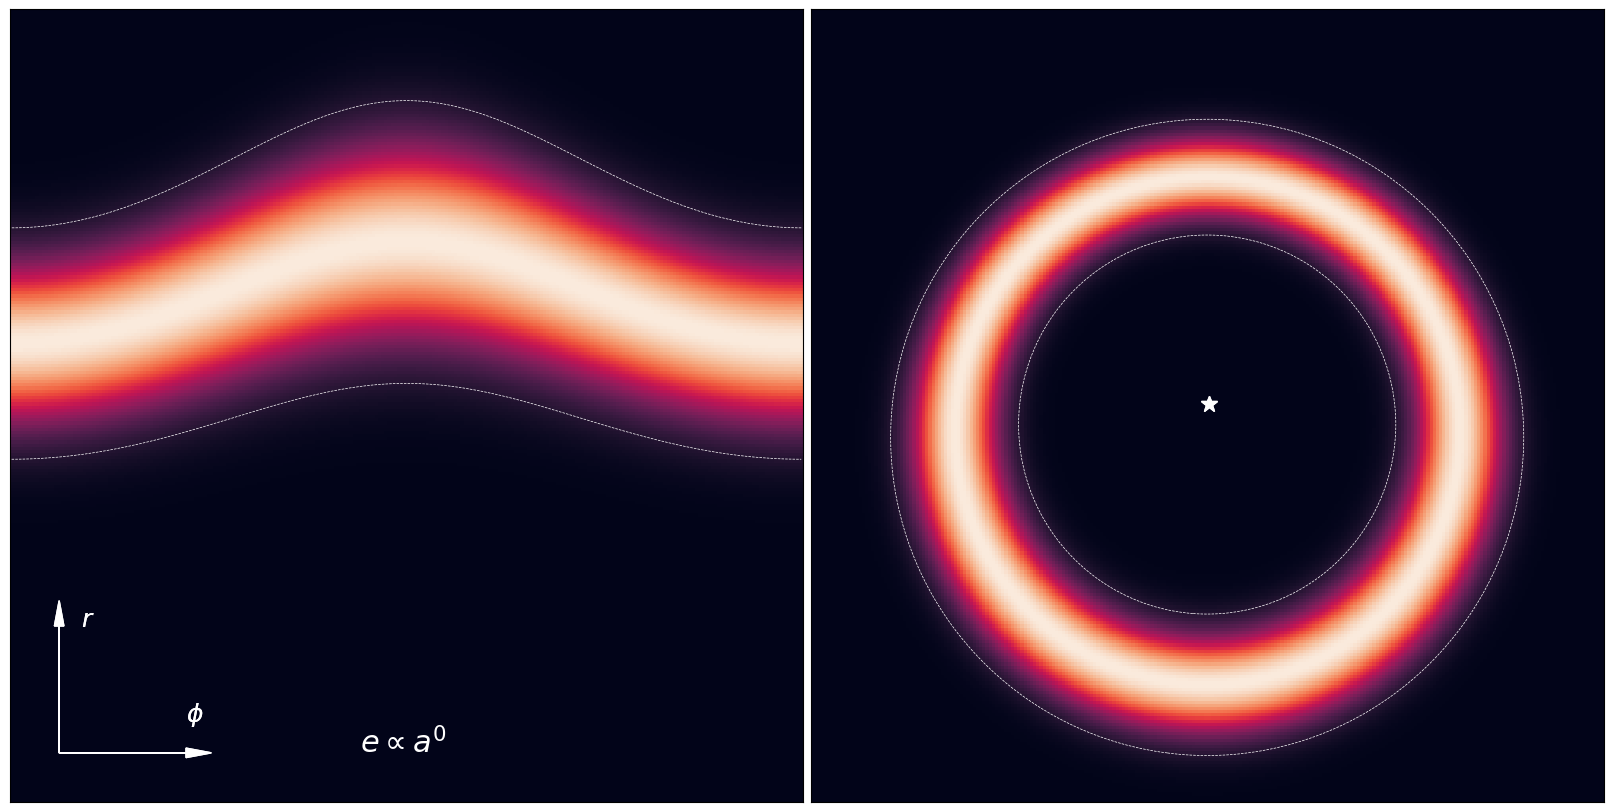

In [99]:
Sigma_prn_0, Sigma_prn_0C = getEccentricRing(gridParams, eRingParams, norm=True)
drawEccentricModels(Sigma_prn_0,Sigma_prn_0C,axisText=r'$e\propto a^{0}$')

### we have an eccentric ring model!

https://imgur.com/star-wars-dot-gif-gC1sWhm
:)

For a flat eccentricity profile (i.e., e=constant with a) we can see we get the expected functionality:
- 1) the ring has a constant surface density with semi-major axis, &
- 2) the ring has a slightly larger radial width at apocentre versus pericentre.

But these do not hold when one has a distribution of semi-major axes (see Lovell et. al. 2024 (in prep.), Lovell & Lynch 2023, Lynch & Lovell 2022). I'll show a couple of cases of this next.

# 1: What if eccentricity rises with semi-major axis?

We can merge a few of the steps outlined above and cut to the chase faster now in these next two exercises.

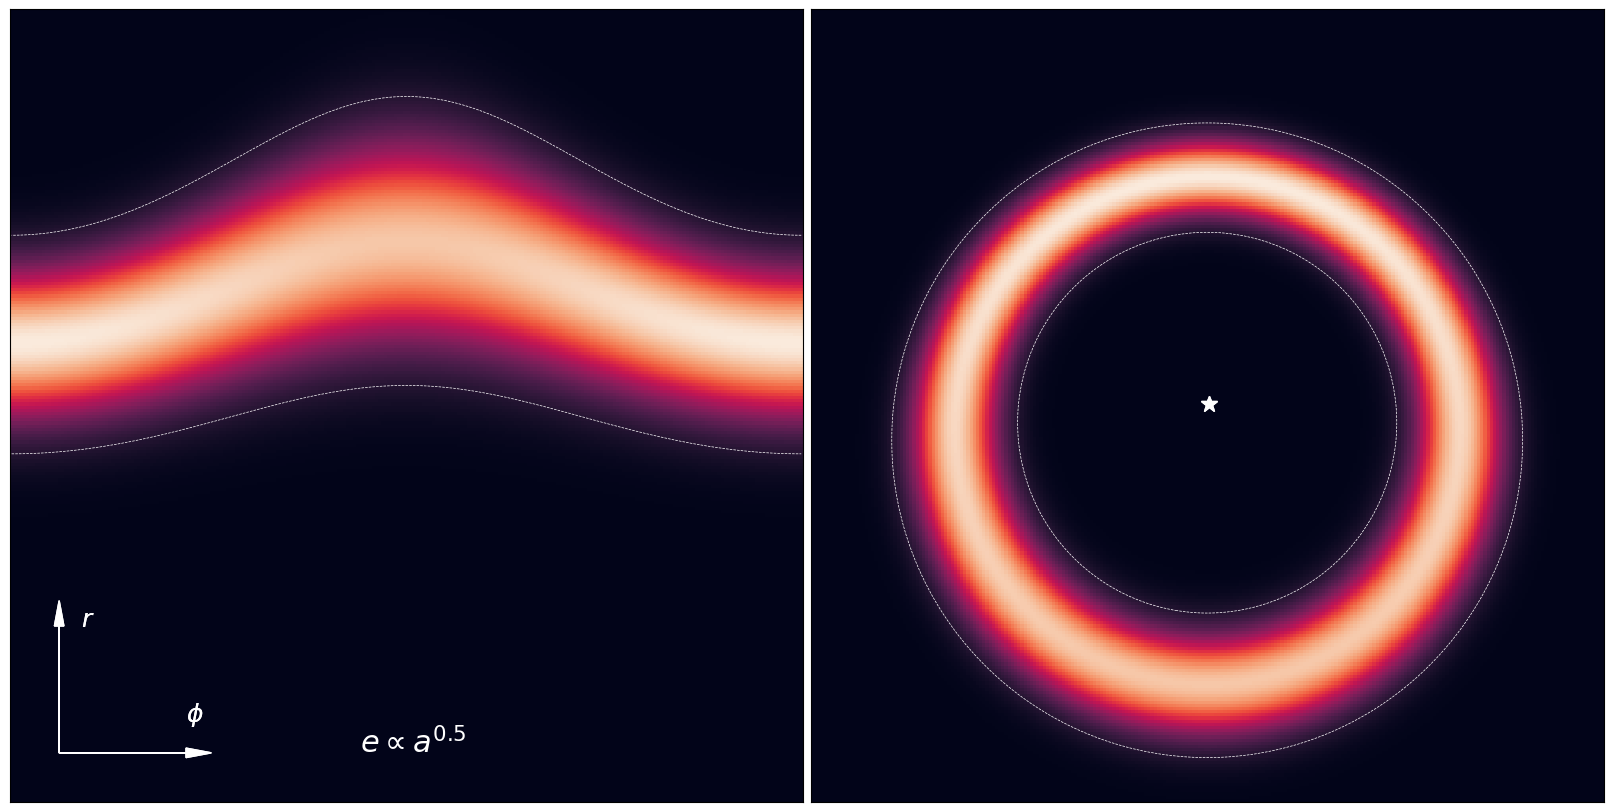

In [100]:
# let's choose some new parameters
r0, e0, wring, omegaf, npow = 90.0, 0.1, 25.0, 0.0, 0.5
Kcon = e0*r0**(-npow) #this parametrisation of Kcon is used but could be incorporated into the function
profileChoice = 'Gaussian' #'Tophat'
eRingParams = [r0, wring, Kcon, npow, omegaf, profileChoice]

Sigma_prn_1, Sigma_prn_1C = getEccentricRing(gridParams, eRingParams, norm=True)
drawEccentricModels(Sigma_prn_1,Sigma_prn_1C,axisText=r'$e\propto a^{0.5}$')

So here we can now see that whilst the ring remains broader at apocentre, the surface density is strongly enhanced at pericentre.

Note that orbital intersections rapidly become a problem for rising e. You can test e~a to see the problem here... but it isn't pretty.

Now, let's look at the opposite case.

# 2: What if eccentricity falls with semi-major axis?

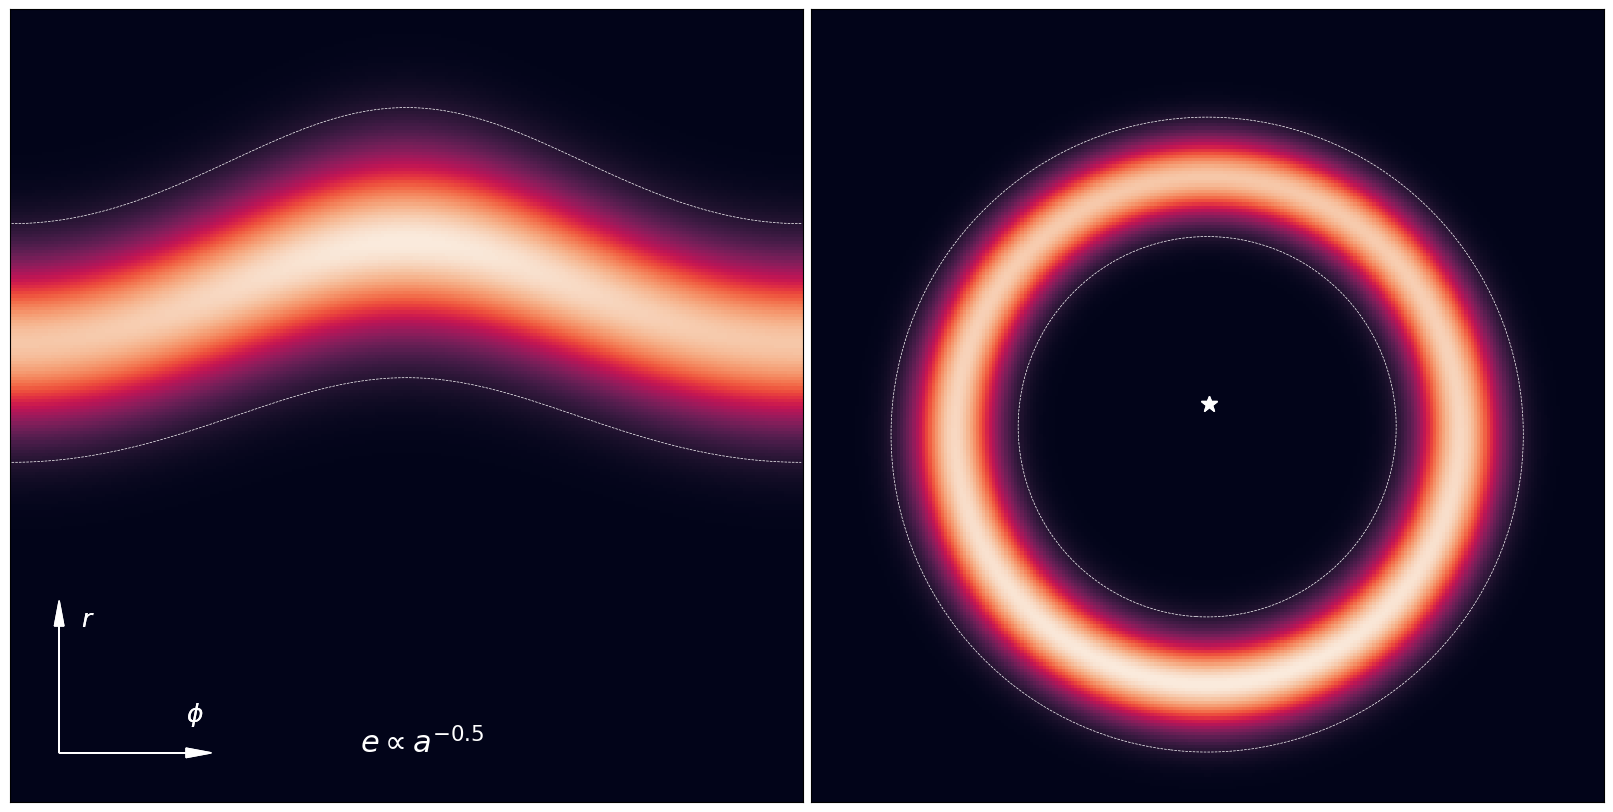

In [101]:
# let's choose some new parameters
r0, e0, wring, omegaf, npow = 90.0, 0.1, 25.0, 0.0, -0.5
Kcon = e0*r0**(-npow) #this parametrisation of Kcon is used but could be incorporated into the function
profileChoice = 'Gaussian' #'Tophat'
eRingParams = [r0, wring, Kcon, npow, omegaf, profileChoice]

Sigma_prn_1, Sigma_prn_1C = getEccentricRing(gridParams, eRingParams, norm=True)
drawEccentricModels(Sigma_prn_1,Sigma_prn_1C,axisText=r'$e\propto a^{-0.5}$')

Instead, here we see that whilst the ring remains broader at apocentre, this has been narrowed versus the previous plot. Note however that the surface density is strongly enhanced at apocentre -- i.e., the eccentricity gradient has flipped the surface density peak, and altered the ring width with azimuth.

Now, let's look at a more extreme case.

# 3: What if eccentricity steeply falls with semi-major axis?

In [ ]:
# let's choose some new parameters
r0, e0, wring, omegaf, npow = 90.0, 0.1, 25.0, 0.0, -2.5
Kcon = e0*r0**(-npow) #this parametrisation of Kcon is used but could be incorporated into the function
profileChoice = 'Gaussian' #'Tophat'
eRingParams = [r0, wring, Kcon, npow, omegaf, profileChoice]

Sigma_prn_1, Sigma_prn_1C = getEccentricRing(gridParams, eRingParams, norm=True)
drawEccentricModels(Sigma_prn_1,Sigma_prn_1C,axisText=r'$e\propto a^{-2.5}$')

Wow -- now we can see both that there's a very strong apocentre density enhancement, and a width decrement at apocentre. 

Not only is the eccentricity gradient ensuring a higher density of material is present at apocentre (on the same orbital semi-major axis) it is also narrowing the ring towards the apocentre.

# More complicated eccentricity profiles
These are possible, for example, by including fixed forced and free eccentricities (Lovell & Lynch 2023), fixed forced and distributions in free eccentricity (Kennedy 2020). I will update this tutorial to include these disk models soon.

# More complicated radial profiles
These are easily introduced by altering the return line in the eccentricity definitions. For now I have only included Gaussian and tophat distributions, however power-laws, double Gaussians, asymmetric Gaussians, double-power-laws, Rayleigh distributions etc are all alternatives one can code instead and have been used in the literature. Just be careful to correctly normalise and implement the Jacobian determinant in your denominator.